### Epochs = 20, Learning rate = 0.0001, batch size = 16, image size = 256x256 + data augmentations + cat weighting

#### Adding dog and cat breed names to prompts

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from scipy.ndimage import gaussian_filter, map_coordinates
import clip
import matplotlib.pyplot as plt

# Set random seed for reproducibility
if torch.cuda.is_available():
    torch.cuda.manual_seed(100)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
class JointTransform:
    def __init__(self, img_size=256, crop_size=224, p_flip=0.5, p_rotate=0.3, p_elastic=0.3):
        """
        Joint transformation for image and mask.
        
        Args:
            img_size: Initial size to resize images to (e.g., 256)
            crop_size: Size to crop images to after resize (e.g., 224 for CLIP)
            p_flip: Probability of horizontal flip
            p_rotate: Probability of random rotation
            p_elastic: Probability of elastic transformation
        """
        self.img_size = img_size        # Initial size to resize to
        self.crop_size = crop_size      # CLIP's expected size
        self.p_flip = p_flip
        self.p_rotate = p_rotate
        self.p_elastic = p_elastic
        
        # For elastic transform
        self.elastic_alpha = 25
        self.elastic_sigma = 3
    
    def __call__(self, image, mask):
        # Resize both to the initial larger size
        image = TF.resize(image, (self.img_size, self.img_size))
        mask = TF.resize(mask, (self.img_size, self.img_size), interpolation=TF.InterpolationMode.NEAREST)
        
        # Random horizontal flip
        if random.random() < self.p_flip:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
            
        # Random rotation (-30 to 30 degrees)
        if random.random() < self.p_rotate:
            angle = random.uniform(-30, 30)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle, interpolation=TF.InterpolationMode.NEAREST)
        
        # Random crop to final size (CLIP expected size)
        i, j, h, w = transforms.RandomCrop.get_params(image, (self.crop_size, self.crop_size))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        
        # Elastic transformation (only if probability threshold met)
        if random.random() < self.p_elastic:
            image, mask = self._elastic_transform(image, mask)
        
        # Color jitter (image only)
        image = TF.adjust_brightness(image, random.uniform(0.8, 1.2))
        image = TF.adjust_contrast(image, random.uniform(0.8, 1.2))
        image = TF.adjust_saturation(image, random.uniform(0.8, 1.2))
        
        # Convert to tensor
        image = TF.to_tensor(image)
        mask = torch.from_numpy(np.array(mask)).long()
        
        return image, mask
    
    def _elastic_transform(self, image, mask):
        """Apply elastic transformation on image and mask"""
        image_np = np.array(image)
        mask_np = np.array(mask)
        
        # Create displacement fields
        shape = image_np.shape[:2]
        dx = np.random.rand(*shape) * 2 - 1
        dy = np.random.rand(*shape) * 2 - 1
        
        # Smooth displacement fields
        dx = gaussian_filter(dx, sigma=self.elastic_sigma) * self.elastic_alpha
        dy = gaussian_filter(dy, sigma=self.elastic_sigma) * self.elastic_alpha
        
        # Create mesh grid
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
        
        # Apply displacement on image
        distorted_image = np.zeros(image_np.shape)
        for c in range(3):
            distorted_image[:,:,c] = map_coordinates(image_np[:,:,c], indices, order=1).reshape(shape)
        
        # Apply displacement on mask (using nearest to preserve labels)
        distorted_mask = map_coordinates(mask_np, indices, order=0).reshape(shape)
        
        return Image.fromarray(distorted_image.astype(np.uint8)), Image.fromarray(distorted_mask.astype(np.uint8))

In [7]:
class PetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, target_transform=None):
        """
        Args:
            root_dir (string): Directory with the dataset.
            split (string): 'train', 'val', or 'test' split.
            transform (callable, optional): Transform to be applied on the input image.
            target_transform (callable, optional): Transform to be applied on the mask.
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.target_transform = target_transform
        
        # Set paths for images and masks
        self.image_dir = os.path.join(root_dir, split, 'color')
        self.mask_dir = os.path.join(root_dir, split, 'label')
        
        # Get all image file names
        self.image_files = sorted([f for f in os.listdir(self.image_dir) 
                                  if os.path.isfile(os.path.join(self.image_dir, f))])
        
        # Initialize the breeds list with correct extraction
        self.breeds = []
        self._cat_breeds = self._get_cat_breeds()
        self._dog_breeds = self._get_dog_breeds()
        
        # Now extract breed info for each file
        for img_file in self.image_files:
            self.breeds.append(self._get_breed_info(img_file))
    
    def _get_cat_breeds(self):
        """Return dictionary of cat breeds"""
        return {
            'abyssinian': 'Abyssinian',
            'bengal': 'Bengal',
            'birman': 'Birman',
            'bombay': 'Bombay',
            'british_shorthair': 'British Shorthair',
            'egyptian_mau': 'Egyptian Mau',
            'maine_coon': 'Maine Coon',
            'persian': 'Persian',
            'ragdoll': 'Ragdoll',
            'russian_blue': 'Russian Blue',
            'siamese': 'Siamese',
            'sphynx': 'Sphynx'
        }
    
    def _get_dog_breeds(self):
        """Return dictionary of dog breeds"""
        return {
            'american_bulldog': 'American Bulldog',
            'american_pit_bull_terrier': 'American Pit Bull Terrier',
            'basset_hound': 'Basset Hound',
            'beagle': 'Beagle',
            'boxer': 'Boxer',
            'chihuahua': 'Chihuahua',
            'english_cocker_spaniel': 'English Cocker Spaniel',
            'english_setter': 'English Setter',
            'german_shorthaired': 'German Shorthaired',
            'great_pyrenees': 'Great Pyrenees',
            'havanese': 'Havanese',
            'japanese_chin': 'Japanese Chin',
            'keeshond': 'Keeshond',
            'leonberger': 'Leonberger',
            'miniature_pinscher': 'Miniature Pinscher',
            'newfoundland': 'Newfoundland',
            'pomeranian': 'Pomeranian',
            'pug': 'Pug',
            'saint_bernard': 'Saint Bernard',
            'samoyed': 'Samoyed',
            'scottish_terrier': 'Scottish Terrier',
            'shiba_inu': 'Shiba Inu',
            'staffordshire_bull_terrier': 'Staffordshire Bull Terrier',
            'wheaten_terrier': 'Wheaten Terrier',
            'yorkshire_terrier': 'Yorkshire Terrier'
        }
    
    def _get_breed_info(self, filename):
        """
        Ultra-simple breed extraction directly from filename
        """
        # Remove file extension
        base_name = os.path.splitext(filename)[0]
        
        # Split by underscore
        parts = base_name.split('_')
        
        # Remove numeric suffix if present
        if len(parts) > 1 and parts[-1].isdigit():
            breed_parts = parts[:-1]
        else:
            breed_parts = parts
        
        # Join parts back together for the breed key
        breed_key = '_'.join(breed_parts).lower()
        
        # Check if it's a dog breed
        if breed_key in self._dog_breeds:
            return (f"{self._dog_breeds[breed_key]} dog", 2)
        
        # Check if it's a cat breed
        if breed_key in self._cat_breeds:
            return (f"{self._cat_breeds[breed_key]} cat", 1)
        
        # Fallback
        return ("Unknown pet", 0)
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        # Get corresponding mask file
        mask_name = img_name.replace('.jpg', '.png')
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        # Load image and mask
        image = Image.open(img_path).convert('RGB')
        
        # Load and process mask
        mask = Image.open(mask_path).convert('RGB')
        mask_np = np.array(mask)
        
        # Convert RGB mask to class indices
        seg_mask = np.zeros(mask_np.shape[:2], dtype=np.uint8)
        
        # Background (black)
        black_mask = (mask_np[:,:,0] == 0) & (mask_np[:,:,1] == 0) & (mask_np[:,:,2] == 0)
        seg_mask[black_mask] = 0
        # Cat (red)
        red_mask = (mask_np[:,:,0] == 128) & (mask_np[:,:,1] == 0) & (mask_np[:,:,2] == 0)
        seg_mask[red_mask] = 1
        # Dog (green)
        green_mask = (mask_np[:,:,0] == 0) & (mask_np[:,:,1] == 128) & (mask_np[:,:,2] == 0)
        seg_mask[green_mask] = 2
        # White border (ignore)
        white_mask = (mask_np[:,:,0] == 255) & (mask_np[:,:,1] == 255) & (mask_np[:,:,2] == 255)
        seg_mask[white_mask] = 255  # Use 255 as ignore index
        
        # Create a PIL Image from the segmentation mask
        seg_mask_pil = Image.fromarray(seg_mask)
        
        # Apply joint transformations
        if self.transform:
            image, seg_mask = self.transform(image, seg_mask_pil)
        else:
            # Convert to tensor if no transform
            image = TF.to_tensor(Image.fromarray(np.array(image)))
            seg_mask = torch.from_numpy(seg_mask).long()
        
        # Get breed information
        breed, _ = self.breeds[idx]
        
        return image, seg_mask, breed

In [9]:
# Create datasets
data_root = '../Dataset/'  # Adjust path as needed
trainval_dataset = PetDataset(data_root, 'TrainVal', transform=joint_transform)
train_size = int(0.8 * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size

# For training/validation split
train_indices, val_indices = torch.utils.data.random_split(
    range(len(trainval_dataset)), [train_size, val_size]
)

# Create datasets with appropriate transforms
train_dataset = PetDataset(data_root, 'TrainVal', transform=joint_transform)
train_dataset.image_files = [trainval_dataset.image_files[i] for i in train_indices.indices]
# IMPORTANT: Regenerate the breeds list to match the new image files order
train_dataset.breeds = []
for img_file in train_dataset.image_files:
    train_dataset.breeds.append(train_dataset._get_breed_info(img_file))

val_dataset = PetDataset(data_root, 'TrainVal', transform=val_transform)
val_dataset.image_files = [trainval_dataset.image_files[i] for i in val_indices.indices]
# IMPORTANT: Regenerate the breeds list to match the new image files order
val_dataset.breeds = []
for img_file in val_dataset.image_files:
    val_dataset.breeds.append(val_dataset._get_breed_info(img_file))

test_dataset = PetDataset(data_root, 'Test', transform=val_transform)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Custom collate function to handle the breed information
def collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    masks = torch.stack([item[1] for item in batch])
    breeds = [item[2] for item in batch]
    return images, masks, breeds

# Create dataloaders with the custom collate function
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)

# Verify breed extraction
print("\nVerifying breeds after splitting:")
for i in range(5):
    print(f"Image file: {train_dataset.image_files[i]}")
    print(f"Extracted breed: {train_dataset.breeds[i]}")
    print("---")

NameError: name 'joint_transform' is not defined

In [26]:
model, preprocess = clip.load("ViT-B/32", jit=False)
model.to(device)
# print(f"Using device: {device}")

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [ ]:
class CLIPGuidedSegmentation(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        
        # Load pre-trained CLIP model
        self.clip_model, self.preprocess = clip.load("ViT-B/32", device=device)
        
        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False
            
        # Define background class descriptions (unchanged)
        self.background_texts = [
            "a photo of a plain background", 
            "empty space", 
            "background area"
        ]
        
        # Generate background text features
        with torch.no_grad():
            background_embeddings = []
            for prompt in self.background_texts:
                text_tokens = clip.tokenize([prompt]).to(device)
                embedding = self.clip_model.encode_text(text_tokens)
                embedding = embedding / embedding.norm(dim=-1, keepdim=True)
                background_embeddings.append(embedding)
            
            # Average the embeddings for background
            self.background_embedding = torch.mean(torch.stack(background_embeddings), dim=0)
        
        # Cache for text features
        self.text_features_cache = {}
        
        # Feature dimensions
        self.visual_dim = self.clip_model.visual.output_dim  # Should be 512 for ViT-B/32
        
        # Add a CLIP adapter to better transform visual features
        self.clip_adapter = nn.Sequential(
            nn.Linear(self.visual_dim, self.visual_dim),
            nn.LayerNorm(self.visual_dim),
            nn.GELU(),
            nn.Linear(self.visual_dim, self.visual_dim),
            nn.LayerNorm(self.visual_dim)
        )
        
        # Improved decoder architecture to ensure correct output shape
        self.decoder = nn.Sequential(
            # Reshape features to 2D structure
            nn.Linear(self.visual_dim, 256 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (256, 7, 7)),
            
            # Upsampling to 14x14
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # Upsampling to 28x28
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # Upsampling to 56x56
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            # Upsampling to 112x112
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            # Final upsampling to 224x224
            nn.ConvTranspose2d(16, num_classes, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
    
    def get_text_features(self, breed):
        """
        Get text features for a breed. Cache results for efficiency.
        
        Args:
            breed (str): Breed name (e.g., "Abyssinian cat" or "American Bulldog dog")
        
        Returns:
            torch.Tensor: Text features for the breed
        """
        if breed in self.text_features_cache:
            return self.text_features_cache[breed]
        
        with torch.no_grad():

            
            # Encode prompts
            embeddings = []
            for prompt in prompts:
                text_tokens = clip.tokenize([prompt]).to(device)
                embedding = self.clip_model.encode_text(text_tokens)
                embedding = embedding / embedding.norm(dim=-1, keepdim=True)
                embeddings.append(embedding)
            
            # Average embeddings
            breed_embedding = torch.mean(torch.stack(embeddings), dim=0)
            
            # Cache for future use
            self.text_features_cache[breed] = breed_embedding
            
            return breed_embedding
    
    def forward(self, x, breeds=None):
        """
        Forward pass with breed-specific text features.
        
        Args:
            x (torch.Tensor): Batch of images
            breeds (list, optional): List of breed names. If None, uses generic prompts.
        
        Returns:
            torch.Tensor: Segmentation prediction
        """
        # Extract image features
        with torch.no_grad():
            image_features = self.clip_model.encode_image(x)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            image_features = image_features.float()
        
        # Apply CLIP adapter
        image_features = self.clip_adapter(image_features)
        
        # Generate segmentation mask from image features
        segmentation = self.decoder(image_features)
        
        # Ensure the output has the correct shape
        if segmentation.shape[2:] != x.shape[2:]:
            segmentation = nn.functional.interpolate(
                segmentation, 
                size=x.shape[2:], 
                mode='bilinear', 
                align_corners=False
            )
        
        return segmentation

In [28]:
def train_clip_segmentation(model, train_loader, val_loader, num_epochs=50, cat_weight=2.1, device=device):
    """
    Train the CLIP-based segmentation model with breed-specific prompts.
    
    Args:
        model: CLIP-based segmentation model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: Number of epochs to train
        cat_weight: Weight for cat class to address class imbalance
        device: Device to train on
        
    Returns:
        Trained model
    """
    # Define class weights to address class imbalance [background, cat, dog]
    class_weights = torch.tensor([1.0, cat_weight, 1.0], device=device)

    # Define loss function with class weights and ignore_index for white pixels
    criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=255)
    
    # Define optimizer - only train the decoder part since CLIP is frozen
    optimizer = optim.Adam(model.decoder.parameters(), lr=0.0001)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Track best model
    best_val_loss = float('inf')
    best_model = None
    
    # Training history
    train_losses = []
    val_losses = []
    prev_lr = optimizer.param_groups[0]['lr']
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for images, masks, breeds in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
            # Move data to device
            images = images.to(device)
            masks = masks.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass with breed information
            outputs = model(images, breeds)
            
            # Calculate loss
            loss = criterion(outputs, masks)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track loss
            running_loss += loss.item() * images.size(0)
        
        # Calculate average training loss
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        
        with torch.no_grad():
            for images, masks, breeds in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)"):
                # Move data to device
                images = images.to(device)
                masks = masks.to(device)
                
                # Forward pass with breed information
                outputs = model(images, breeds)
                
                # Calculate loss
                loss = criterion(outputs, masks)
                
                # Track loss
                val_running_loss += loss.item() * images.size(0)
        
        # Calculate average validation loss
        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Manually check for learning rate changes
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr != prev_lr:
            print(f"Learning rate changed from {prev_lr:.6f} to {current_lr:.6f}")
            prev_lr = current_lr
        
        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"LR: {current_lr:.6f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()
            print(f"New best model saved with validation loss: {val_loss:.4f}")
    
    # Load best model
    model.load_state_dict(best_model)
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    return model

Training CLIP-based segmentation model...


Epoch 1/20 (Val): 100%|██████████| 46/46 [00:31<00:00,  1.48it/s]


Epoch [1/20], Train Loss: 0.9297, Val Loss: 0.7246, LR: 0.000100
New best model saved with validation loss: 0.7246


Epoch 2/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.63it/s]


Epoch [2/20], Train Loss: 0.7280, Val Loss: 0.5903, LR: 0.000100
New best model saved with validation loss: 0.5903


Epoch 3/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.71it/s]


Epoch [3/20], Train Loss: 0.6278, Val Loss: 0.5219, LR: 0.000100
New best model saved with validation loss: 0.5219


Epoch 4/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.67it/s]


Epoch [4/20], Train Loss: 0.5695, Val Loss: 0.4641, LR: 0.000100
New best model saved with validation loss: 0.4641


Epoch 5/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.79it/s]


Epoch [5/20], Train Loss: 0.5397, Val Loss: 0.4368, LR: 0.000100
New best model saved with validation loss: 0.4368


Epoch 6/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 10.29it/s]


Epoch [6/20], Train Loss: 0.5185, Val Loss: 0.4276, LR: 0.000100
New best model saved with validation loss: 0.4276


Epoch 7/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.97it/s]


Epoch [7/20], Train Loss: 0.5025, Val Loss: 0.4142, LR: 0.000100
New best model saved with validation loss: 0.4142


Epoch 8/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.70it/s]


Epoch [8/20], Train Loss: 0.4878, Val Loss: 0.3953, LR: 0.000100
New best model saved with validation loss: 0.3953


Epoch 9/20 (Val): 100%|██████████| 46/46 [00:10<00:00,  4.45it/s]


Epoch [9/20], Train Loss: 0.4762, Val Loss: 0.4072, LR: 0.000100


Epoch 10/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.42it/s]


Epoch [10/20], Train Loss: 0.4683, Val Loss: 0.3881, LR: 0.000100
New best model saved with validation loss: 0.3881


Epoch 11/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.43it/s]


Epoch [11/20], Train Loss: 0.4657, Val Loss: 0.3871, LR: 0.000100
New best model saved with validation loss: 0.3871


Epoch 12/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.76it/s]


Epoch [12/20], Train Loss: 0.4572, Val Loss: 0.3761, LR: 0.000100
New best model saved with validation loss: 0.3761


Epoch 13/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.49it/s]


Epoch [13/20], Train Loss: 0.4573, Val Loss: 0.3720, LR: 0.000100
New best model saved with validation loss: 0.3720


Epoch 14/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.76it/s]


Epoch [14/20], Train Loss: 0.4430, Val Loss: 0.3715, LR: 0.000100
New best model saved with validation loss: 0.3715


Epoch 15/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.80it/s]


Epoch [15/20], Train Loss: 0.4461, Val Loss: 0.3730, LR: 0.000100


Epoch 16/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.97it/s]


Epoch [16/20], Train Loss: 0.4449, Val Loss: 0.3652, LR: 0.000100
New best model saved with validation loss: 0.3652


Epoch 17/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.73it/s]


Epoch [17/20], Train Loss: 0.4420, Val Loss: 0.3738, LR: 0.000100


Epoch 18/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 10.04it/s]


Epoch [18/20], Train Loss: 0.4411, Val Loss: 0.3685, LR: 0.000100


Epoch 19/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 10.02it/s]


Epoch [19/20], Train Loss: 0.4368, Val Loss: 0.3673, LR: 0.000100


Epoch 20/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.93it/s]

Epoch [20/20], Train Loss: 0.4308, Val Loss: 0.3669, LR: 0.000100


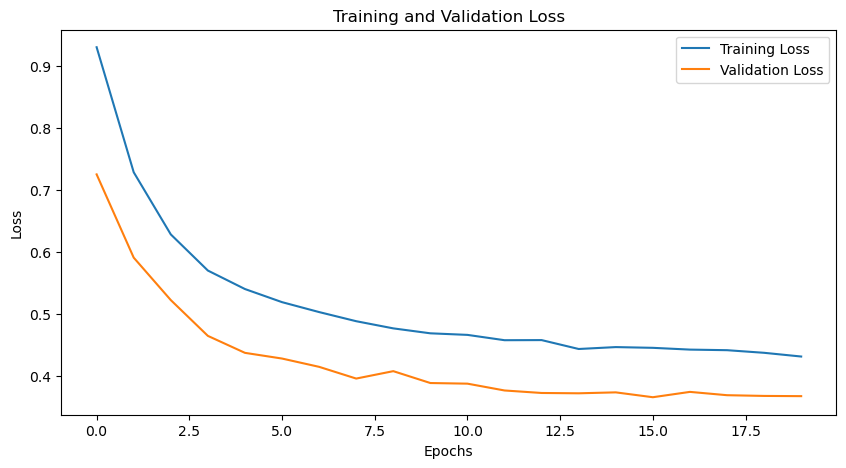

Model saved to clip_segmentation.pth


In [29]:
# Create CLIP-based segmentation model
clip_segmentation = CLIPGuidedSegmentation(num_classes=3).to(device)

# Train CLIP segmentation model
print("Training CLIP-based segmentation model...")
num_epochs = 20  # Adjust as needed
cat_weight = 2.1
clip_segmentation = train_clip_segmentation(clip_segmentation, train_loader, val_loader, 
                                          num_epochs=num_epochs, cat_weight=cat_weight, device=device)

# Save the trained model
torch.save(clip_segmentation.state_dict(), 'clip_segmentation.pth')
print("Model saved to clip_segmentation.pth")

In [30]:
def evaluate_clip_segmentation(model, dataloader, device):
    """
    Evaluate the CLIP-based segmentation model with breed-specific prompts.
    
    Args:
        model: CLIP-based segmentation model
        dataloader: DataLoader for evaluation data
        device: Device to evaluate on
        
    Returns:
        Dictionary of evaluation metrics
    """
    model.eval()
    
    # Initialize metrics
    correct = 0
    total = 0
    
    # Initialize IoU metrics - one for each class
    num_classes = 3  # background (0), cat (1), dog (2)
    intersection = torch.zeros(num_classes, device=device)
    union = torch.zeros(num_classes, device=device)
    
    with torch.no_grad():
        for images, masks, breeds in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            
            # Get predictions with breed information
            outputs = model(images, breeds)
            _, predicted = torch.max(outputs, 1)
            
            # Calculate accuracy (ignoring white pixels with value 255)
            mask = (masks != 255)
            correct += (predicted[mask] == masks[mask]).sum().item()
            total += mask.sum().item()
            
            # Calculate IoU for each class
            for cls in range(num_classes):
                pred_cls = (predicted == cls) & mask
                true_cls = (masks == cls) & mask
                
                # Intersection and union
                intersection[cls] += (pred_cls & true_cls).sum().item()
                union[cls] += (pred_cls | true_cls).sum().item()
    
    # Calculate metrics
    accuracy = correct / total if total > 0 else 0
    
    # Calculate IoU for each class
    class_names = ["background", "cat", "dog"]
    class_ious = []
    
    for cls in range(num_classes):
        iou = intersection[cls] / union[cls] if union[cls] > 0 else 0
        class_ious.append(iou)
        print(f"IoU for {class_names[cls]}: {iou:.4f}")
    
    # Calculate mean IoU
    mean_iou = sum(class_ious) / len(class_ious)
    
    print(f"Pixel Accuracy: {accuracy:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")
    
    return {
        "pixel_accuracy": accuracy,
        "class_ious": {class_names[i]: class_ious[i] for i in range(num_classes)},
        "mean_iou": mean_iou
    }

# Evaluate model on validation set
print("\nEvaluating CLIP-based segmentation model on validation set:")
val_results = evaluate_clip_segmentation(clip_segmentation, val_loader, device)


Evaluating CLIP-based segmentation model on validation set:


Evaluating: 100%|██████████| 46/46 [00:04<00:00,  9.96it/s]

IoU for background: 0.7787
IoU for cat: 0.6152
IoU for dog: 0.6191
Pixel Accuracy: 0.8367
Mean IoU: 0.6710


In [31]:
def visualize_clip_segmentation_results(model, dataloader, device, num_samples=3):
    """
    Visualize the CLIP-guided segmentation model predictions with breed information.
    
    Args:
        model: CLIP-guided segmentation model
        dataloader: DataLoader for visualization data
        device: Device to visualize on
        num_samples: Number of samples to visualize
    """
    model.eval()
    
    # Get a batch of samples
    dataiter = iter(dataloader)
    images, masks, breeds = next(dataiter)
    
    # Make sure we don't visualize more than what's available
    num_samples = min(num_samples, images.size(0))
    
    # Class colors for visualization
    colors = torch.tensor([
        [0, 0, 0],      # Background (black)
        [128, 0, 0],    # Cat (red)
        [0, 128, 0]     # Dog (green)
    ], dtype=torch.uint8)
    
    with torch.no_grad():
        # Get predictions with breed information
        outputs = model(images[:num_samples].to(device), breeds[:num_samples])
        _, predicted = torch.max(outputs, 1)
        
        # Create visualization
        fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
        
        for i in range(num_samples):
            # Original image
            img = images[i].cpu().permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)
            axs[i, 0].imshow(img)
            axs[i, 0].set_title(f'Original Image: {breeds[i]}')
            axs[i, 0].axis('off')
            
            # Ground truth mask
            mask = masks[i].cpu().numpy()
            mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
            for j in range(3):  # 3 classes
                mask_rgb[mask == j] = colors[j].numpy()
            # Make ignored regions white
            mask_rgb[mask == 255] = [255, 255, 255]
            
            axs[i, 1].imshow(mask_rgb)
            axs[i, 1].set_title('Ground Truth Mask')
            axs[i, 1].axis('off')
            
            # Predicted mask
            pred = predicted[i].cpu().numpy()
            pred_rgb = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
            for j in range(3):  # 3 classes
                pred_rgb[pred == j] = colors[j].numpy()
            
            # Also make ignored regions white in prediction visualization
            pred_rgb[mask == 255] = [255, 255, 255]
            axs[i, 2].imshow(pred_rgb)
            axs[i, 2].set_title('Predicted Mask')
            axs[i, 2].axis('off')
        
        plt.tight_layout()
        plt.show()


Visualizing CLIP-based segmentation results on validation set:


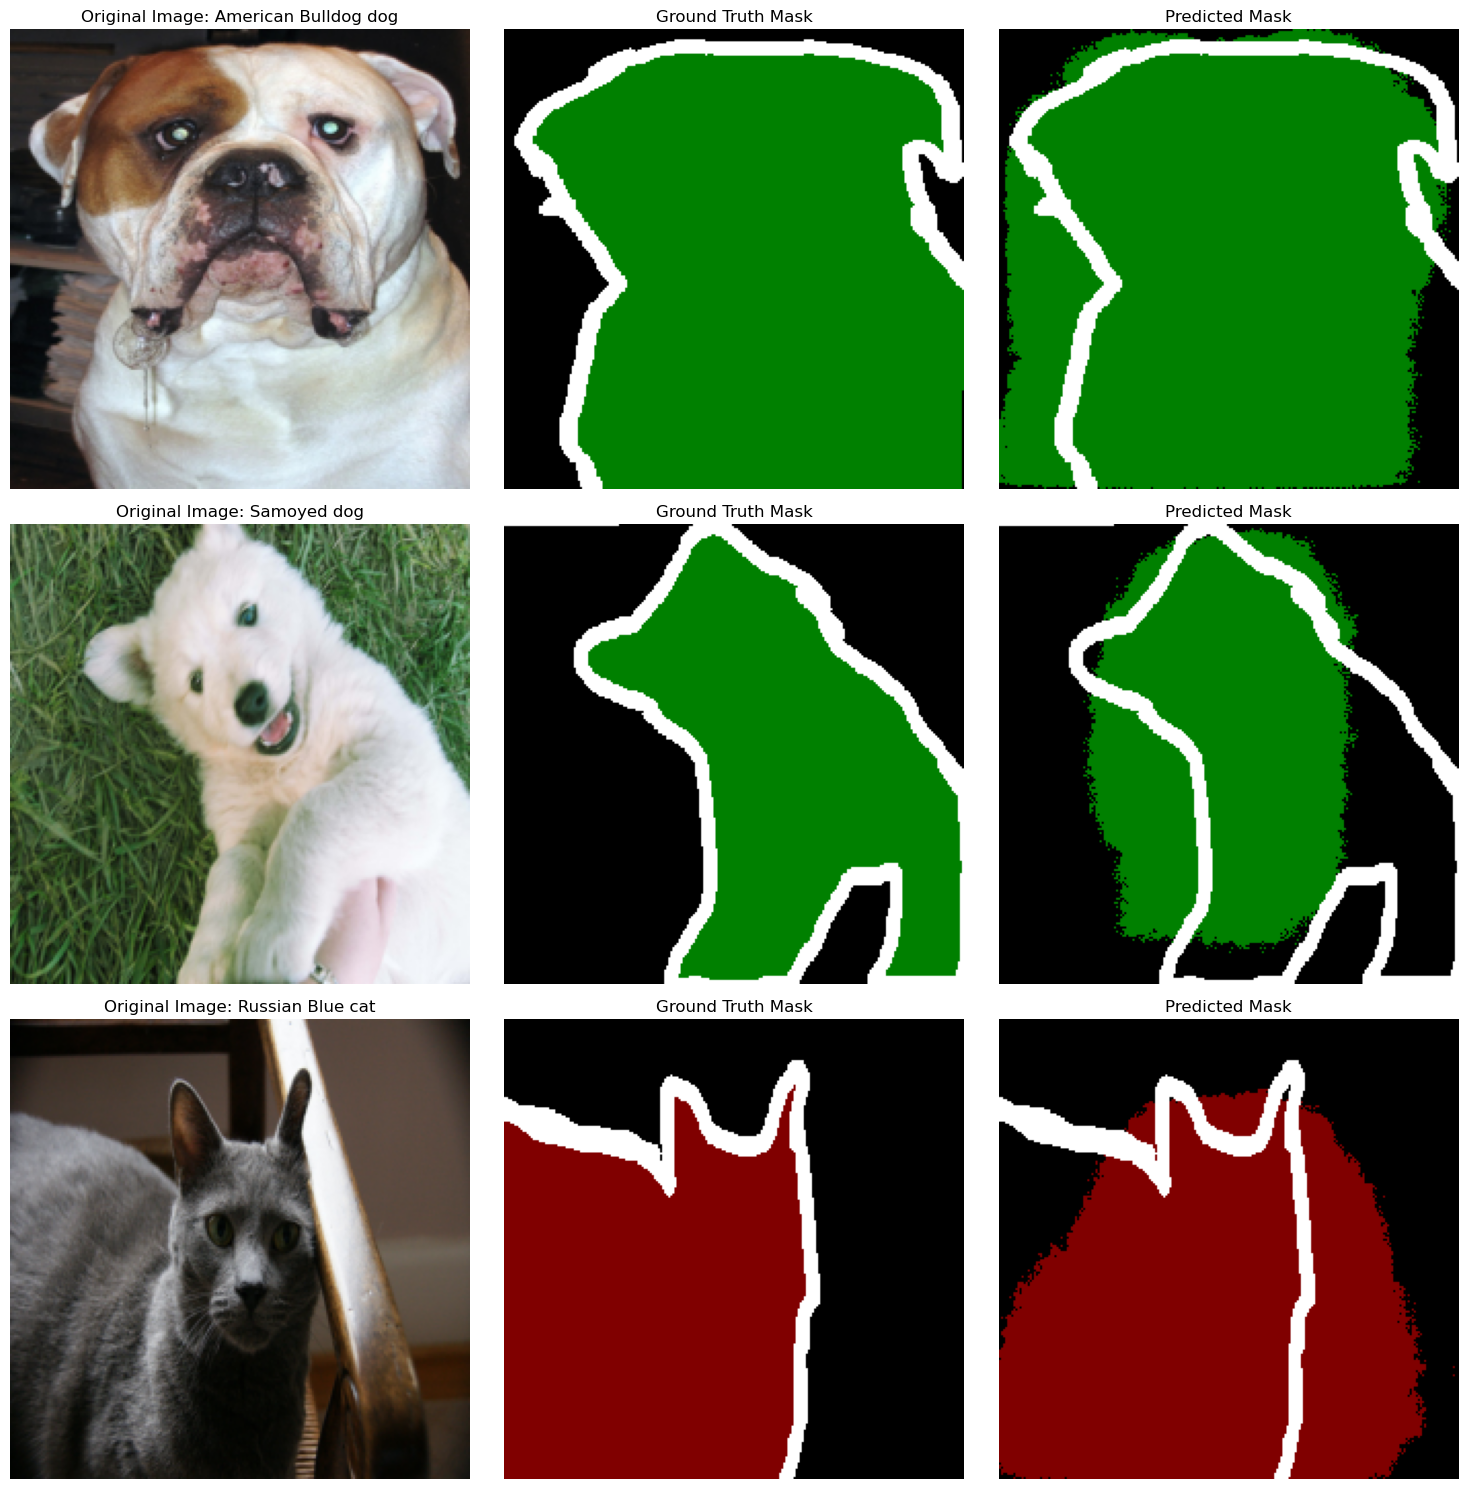

In [32]:
# Visualize results
print("\nVisualizing CLIP-based segmentation results on validation set:")
visualize_clip_segmentation_results(clip_segmentation, val_loader, device, num_samples=3)